In [1]:
import numpy as np
import math
import random
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers import Conv2D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling2D, Flatten
from keras.models import Model, Sequential
from keras import backend as K
#K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
def load_data_splits(base_path='C:\\Users\\dylin\\Documents\\BA_Glare_Effect\\classification_data_initial\\features\\', splits=20):
    real_data_splits_train = []
    real_data_splits_test = []
    simulated_data_splits_train = []
    for split in range(1, splits + 1):
        # Real data for training
        X_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\X_realData_train.npy' %str(split))
        y_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\y_realData_train.npy' %str(split))
        real_data_splits_train.append((X_realData_train, y_realData_train))
        
        # Real data for testing
        X_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\X_realData_test.npy' %str(split))
        y_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\y_realData_test.npy' %str(split))
        real_data_splits_test.append((X_realData_test, y_realData_test))
    
        # Simulated data for training
        X_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\X_simulatedData_train.npy' %str(split))
        y_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\y_simulatedData_train.npy' %str(split))
        simulated_data_splits_train.append((X_simulatedData_train, y_simulatedData_train))
    return real_data_splits_train, real_data_splits_test, simulated_data_splits_train

In [3]:
real_data_splits_train, real_data_splits_test, simulated_data_splits_train = load_data_splits()

In [4]:
real_data_split_train, real_data_split_test, simulated_data_split_train = \
    real_data_splits_train[0], real_data_splits_test[0], simulated_data_splits_train[0]

In [5]:
real_data_split_train[1].shape

(38, 2)

In [6]:
def create_image(game, components=[True, True, True, True, True]):
    card_codes = np.zeros((7, 40))
    cards_left = np.zeros((8, 40))
    never_revealed_cards = np.zeros((14, 40))
    max_same_card_reveals = np.zeros((20, 40))
    rounds_since_done = np.zeros((27, 40))
    
    x_position = 0
    
    for step in game:
        card_code = math.floor(step[0])
        first_or_second = int(round((step[0] % 1) * 10))
        
        if card_code != 0:
            card_codes[card_code - 1][x_position] = first_or_second
            
        cards_left[int(step[1] / 2)][x_position] = 1
        never_revealed_cards[int(step[2])][x_position] = 1
        max_same_card_reveals[int(step[3])][x_position] = 1
        rounds_since_done[int(step[4])][x_position] = 1
        
        x_position += 1
        
    # Try leaving out some features and compare results!
    image = np.zeros((0, 40))
    if components[0]:   # Good visual feature for cnn.
        image = np.vstack((image, card_codes))
    if components[1]:
        image = np.vstack((image, max_same_card_reveals))
    if components[2]:   # I think good visual feature for cnn. 
        image = np.vstack((image, rounds_since_done))
    if components[3]:
        image = np.vstack((image, cards_left))
    if components[4]:   # I think this feature is not very usefull for the cnn. 
                        # No big visual difference between being blinded an not. 
        image = np.vstack((image, never_revealed_cards))
    #switched order of statistival features so that they have some space between them.
        
    return image#[::-1]


In [7]:
def create_images_for_split(data, components):
    data_images = []
    for split in trange(len(data)):
        X = data[split][0]
        y = data[split][1]
        images = []
        for game in range(len(X)):
            image = create_image(X[game], components)
            images.append(image)
        split_data = ((images, y))
        data_images.append(split_data)
    return data_images
    
def create_images(components=[True, True, True, True, True]):
    real_data_splits_train_images = create_images_for_split(real_data_splits_train, components)
    real_data_splits_test_images = create_images_for_split(real_data_splits_test, components)
    simulated_data_splits_train_images = create_images_for_split(simulated_data_splits_train, components)
    return real_data_splits_train_images, real_data_splits_test_images, simulated_data_splits_train_images 
    #return real_data_splits_train_images[0][0][24]

In [8]:
real_data_splits_train_images, real_data_splits_test_images, simulated_data_splits_train_images = \
    create_images(components=[True, True, True, True, True])

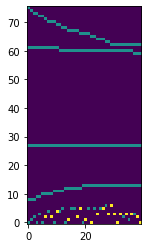

In [9]:
# Unclear noObst indices: 8?, 12
# Unclear glare indices: 23, 26?, 27, 32, 36, 
# Not cortrect validated: glare in split 1, 
# Plan: remove and train best conigs and see if results get better 

plt.imshow(real_data_splits_train_images[0][0][19], origin='lower') 

In [10]:
real_data_splits_train[0][1]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [11]:
real_data_splits_test

[(array([[[ 1.1, 14. , 13. ,  1. ,  0. ],
          [ 1.2, 12. , 12. ,  1. ,  0. ],
          [ 2.1, 12. , 11. ,  1. ,  0. ],
          [ 3.1, 12. , 10. ,  1. ,  0. ],
          [ 4.1, 12. ,  9. ,  1. ,  0. ],
          [ 5.1, 12. ,  8. ,  1. ,  0. ],
          [ 5.2, 12. ,  7. ,  1. ,  0. ],
          [ 5.1, 10. ,  7. ,  2. ,  0. ],
          [ 6.1, 10. ,  6. ,  2. ,  0. ],
          [ 3.2, 10. ,  5. ,  2. ,  0. ],
          [ 3.1, 10. ,  5. ,  2. ,  0. ],
          [ 3.2,  8. ,  5. ,  2. ,  0. ],
          [ 6.2,  8. ,  4. ,  2. ,  0. ],
          [ 4.1,  8. ,  4. ,  2. ,  0. ],
          [ 2.2,  8. ,  3. ,  2. ,  0. ],
          [ 2.1,  6. ,  3. ,  2. ,  0. ],
          [ 7.1,  6. ,  2. ,  2. ,  0. ],
          [ 7.2,  4. ,  1. ,  2. ,  0. ],
          [ 4.2,  4. ,  0. ,  2. ,  0. ],
          [ 6.1,  4. ,  0. ,  2. ,  0. ],
          [ 4.1,  4. ,  0. ,  3. ,  0. ],
          [ 4.2,  2. ,  0. ,  3. ,  0. ],
          [ 6.2,  2. ,  0. ,  3. ,  0. ],
          [ 6.1,  0. ,  0. ,  3. ,

In [12]:
n_participants_per_split = 19 # 20 but one is removed in each split for testing
simulations_per_participant = 1000
n_added_simulations_per_participant = 0
n_runs = 1
n_epochs = 1000

In [13]:
def add_simulated_data(X_train, y_train, simulated_train_set):
    for n in range(n_added_simulations_per_participant):
        for i in range(n_participants_per_split):

            X_train_simulated_1 = simulated_train_set[0][(i * simulations_per_participant) + n]
            y_train_simulated_1 = simulated_train_set[1][(i * simulations_per_participant) + n]
            X_train_simulated_2 = simulated_train_set[0][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            y_train_simulated_2 = simulated_train_set[1][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            
            X_train_simulated = np.concatenate((X_train_simulated_1[np.newaxis, :, :], \
                                               X_train_simulated_2[np.newaxis, :, :]), axis=0)
            y_train_simulated = np.concatenate((y_train_simulated_1[np.newaxis, :], \
                                               y_train_simulated_2[np.newaxis, :]), axis=0)

            X_train = np.concatenate((X_train, X_train_simulated), axis=0)
            y_train = np.concatenate((y_train, y_train_simulated), axis=0)
    return X_train, y_train

In [14]:
def mean_score_of_run(histories, epochs):
    mean_val_losses = []
    mean_val_accuracies = []
    mean_losses = []
    mean_accuracies = []
    for i in range(epochs):
        val_losses = []
        val_accuracies = []
        losses = []
        accuracies = []
        for l in range(len(histories)):
            history = histories[l]
            val_losses.append(history.history['val_loss'][i])
            val_accuracies.append(history.history['val_accuracy'][i])
            losses.append(history.history['loss'][i])
            accuracies.append(history.history['accuracy'][i])
        mean_val_losses.append(np.mean(val_losses))
        mean_val_accuracies.append(np.mean(val_accuracies))
        mean_losses.append(np.mean(losses))
        mean_accuracies.append(np.mean(accuracies))
    return mean_val_losses, mean_val_accuracies, mean_losses, mean_accuracies

In [15]:
def mean_score_over_all_runs(mean_run_scores, n_runs):
    val_losses = np.asarray(mean_run_scores[0][0])
    val_accuracies = np.asarray(mean_run_scores[0][1])
    losses = np.asarray(mean_run_scores[0][2])
    accuracies = np.asarray(mean_run_scores[0][3])
                            
    for i in range(1, n_runs):
        val_losses += np.asarray(mean_run_scores[i][0])
        val_accuracies += np.asarray(mean_run_scores[i][1])
        losses += np.asarray(mean_run_scores[i][2])
        accuracies += np.asarray(mean_run_scores[i][3])
                                 
    val_losses /= n_runs
    val_accuracies /= n_runs
    losses /= n_runs
    accuracies /= n_runs
    
    return val_losses, val_accuracies, losses, accuracies

In [16]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [17]:
def create_and_train(X_train, y_train, X_test, y_test):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    cnn_input_shape = X_train[0].shape
    
    #epochs = n_epochs
    cnn_batch_size = 32 #1000
    #verbose = 0
    
    #print(cnn_input_shape)
    
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), input_shape=(76, 40,1), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=cnn_batch_size, verbose=1, 
                        shuffle=True, validation_data=(X_test, y_test))
    
    #print(history.history['val_accuracy'])
    #print(model.summary())
    
    histories.append(history)
    return model

In [18]:
model = None
mean_run_scores = []
for i in trange(n_runs, desc='Runs'): 
    histories = []
    
    data = list((zip(real_data_splits_train_images, \
                                    real_data_splits_test_images, simulated_data_splits_train_images)))[0]
    train_set, test_set, simulated_train_set = data[0], data[1], data[2]
    
    #for train_set, test_set, simulated_train_set in tqdm(zip(real_data_splits_train_images, \
    #                                real_data_splits_test_images, simulated_data_splits_train_images), total=20, desc='Folds'):
        
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
        
        #print(X_test[0])
        
        #plt.imshow(X_test[1], origin='lower') 
        
        # Adding simulated data. 
    X_train, y_train = add_simulated_data(X_train, y_train, simulated_train_set)   

    print(X_train[0].shape)
    print(y_train.shape) 
    

    # Shuffling training data
    temp_train = list(zip(X_train, y_train.tolist()))
    random.shuffle(temp_train)
    X_train, y_train = zip(*temp_train)

    model = create_and_train(np.asarray(X_train), np.asarray(y_train), np.asarray(X_test), y_test)
        
    mean_run_score = mean_score_of_run(histories=histories, epochs=n_epochs)
    mean_run_scores.append(mean_run_score)

(76, 40)
(38, 2)
Train on 38 samples, validate on 2 samples
Epoch 1/1000
38/38 [==============================] - 1s 14ms/step - loss: 0.6973 - accuracy: 0.4737 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6955 - accuracy: 0.4737 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 4/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.4737 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 5/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6869 - accuracy: 0.5263 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 6/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6987 - accuracy: 0.5263 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 7/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6932 - accu

Epoch 58/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6972 - accuracy: 0.5526 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 59/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6973 - accuracy: 0.3947 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 60/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6986 - accuracy: 0.4737 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 61/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.5526 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 62/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.7045 - accuracy: 0.3684 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 63/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.5789 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 64/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.7003 - accuracy: 0.3947 - val_loss: 0.6936 - val_accuracy: 0.5000

38/38 [==============================] - 0s 7ms/step - loss: 0.6838 - accuracy: 0.6316 - val_loss: 0.6928 - val_accuracy: 1.0000
Epoch 116/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 1.0000
Epoch 117/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.3947 - val_loss: 0.6927 - val_accuracy: 1.0000
Epoch 118/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6948 - accuracy: 0.4737 - val_loss: 0.6926 - val_accuracy: 1.0000
Epoch 119/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5263 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 120/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6875 - accuracy: 0.5263 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 121/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5263 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 1

Epoch 172/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.6978 - accuracy: 0.4737 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 173/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6972 - accuracy: 0.4211 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 174/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5263 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 175/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6866 - accuracy: 0.5789 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 176/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5263 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 177/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.6316 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 178/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5789 - val_loss: 0.6911 - val_accuracy:

Epoch 229/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6964 - accuracy: 0.4737 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 230/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.7105 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 231/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6858 - accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 232/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6956 - accuracy: 0.4474 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 233/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6868 - accuracy: 0.6579 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 234/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6893 - accuracy: 0.5526 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 235/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.5789 - val_loss: 0.6905 - val_accuracy:

Epoch 286/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.7368 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 287/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6860 - accuracy: 0.5789 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 288/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.7007 - accuracy: 0.3947 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 289/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6836 - accuracy: 0.7105 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 290/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6813 - accuracy: 0.6842 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 291/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6878 - accuracy: 0.6316 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 292/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.5526 - val_loss: 0.6901 - val_accuracy:

Epoch 343/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6753 - accuracy: 0.6579 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 344/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6828 - accuracy: 0.6842 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 345/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.4211 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 346/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.6316 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 347/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6872 - accuracy: 0.5263 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 348/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6758 - accuracy: 0.7105 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 349/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6870 - accuracy: 0.4474 - val_loss: 0.6889 - val_accuracy:

Epoch 400/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6675 - accuracy: 0.7632 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 401/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6750 - accuracy: 0.6579 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 402/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6804 - accuracy: 0.6316 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 403/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6666 - accuracy: 0.6842 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 404/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6663 - accuracy: 0.7105 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 405/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6816 - accuracy: 0.5789 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 406/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6865 - accuracy: 0.5526 - val_loss: 0.6877 - val_accuracy:

Epoch 457/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6713 - accuracy: 0.6053 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 458/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6590 - accuracy: 0.7105 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 459/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6797 - accuracy: 0.6579 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 460/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6640 - accuracy: 0.6316 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 461/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6748 - accuracy: 0.5789 - val_loss: 0.6874 - val_accuracy: 0.5000
Epoch 462/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.5000 - val_loss: 0.6874 - val_accuracy: 0.5000
Epoch 463/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6725 - accuracy: 0.5789 - val_loss: 0.6874 - val_accuracy:

Epoch 514/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6546 - accuracy: 0.5789 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 515/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6517 - accuracy: 0.6316 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 516/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.6617 - accuracy: 0.6579 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 517/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6280 - accuracy: 0.7105 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 518/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6560 - accuracy: 0.6316 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 519/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6460 - accuracy: 0.6316 - val_loss: 0.6846 - val_accuracy: 0.5000
Epoch 520/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6549 - accuracy: 0.5526 - val_loss: 0.6845 - val_accuracy:

Epoch 571/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6415 - accuracy: 0.6842 - val_loss: 0.6767 - val_accuracy: 0.5000
Epoch 572/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6095 - accuracy: 0.7895 - val_loss: 0.6767 - val_accuracy: 0.5000
Epoch 573/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6564 - accuracy: 0.7105 - val_loss: 0.6766 - val_accuracy: 0.5000
Epoch 574/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6550 - accuracy: 0.6579 - val_loss: 0.6766 - val_accuracy: 0.5000
Epoch 575/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6297 - accuracy: 0.7895 - val_loss: 0.6765 - val_accuracy: 0.5000
Epoch 576/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6434 - accuracy: 0.7105 - val_loss: 0.6765 - val_accuracy: 0.5000
Epoch 577/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6570 - accuracy: 0.7368 - val_loss: 0.6765 - val_accuracy:

Epoch 628/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5895 - accuracy: 0.8421 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 629/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5973 - accuracy: 0.7632 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 630/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6309 - accuracy: 0.7368 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 631/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6235 - accuracy: 0.7368 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 632/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6275 - accuracy: 0.8158 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 633/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5947 - accuracy: 0.8158 - val_loss: 0.6814 - val_accuracy: 0.5000
Epoch 634/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5979 - accuracy: 0.7105 - val_loss: 0.6811 - val_accuracy:

Epoch 685/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5724 - accuracy: 0.7632 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 686/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6329 - accuracy: 0.6579 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 687/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6106 - accuracy: 0.7105 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 688/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6324 - accuracy: 0.6579 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 689/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5477 - accuracy: 0.8158 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 690/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5753 - accuracy: 0.7632 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 691/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5614 - accuracy: 0.7895 - val_loss: 0.6863 - val_accuracy:

Epoch 742/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4890 - accuracy: 0.8158 - val_loss: 0.7058 - val_accuracy: 0.5000
Epoch 743/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5417 - accuracy: 0.7632 - val_loss: 0.7047 - val_accuracy: 0.5000
Epoch 744/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.4880 - accuracy: 0.7632 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 745/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5434 - accuracy: 0.7895 - val_loss: 0.7028 - val_accuracy: 0.5000
Epoch 746/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5046 - accuracy: 0.7895 - val_loss: 0.7016 - val_accuracy: 0.5000
Epoch 747/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5435 - accuracy: 0.7895 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 748/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5171 - accuracy: 0.7895 - val_loss: 0.7010 - val_accuracy:

Epoch 799/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4981 - accuracy: 0.7632 - val_loss: 0.7527 - val_accuracy: 0.5000
Epoch 800/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5519 - accuracy: 0.7895 - val_loss: 0.7551 - val_accuracy: 0.5000
Epoch 801/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4661 - accuracy: 0.8158 - val_loss: 0.7580 - val_accuracy: 0.5000
Epoch 802/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6542 - accuracy: 0.6579 - val_loss: 0.7606 - val_accuracy: 0.5000
Epoch 803/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4710 - accuracy: 0.8158 - val_loss: 0.7625 - val_accuracy: 0.5000
Epoch 804/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5053 - accuracy: 0.7895 - val_loss: 0.7630 - val_accuracy: 0.5000
Epoch 805/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5189 - accuracy: 0.7632 - val_loss: 0.7631 - val_accuracy:

Epoch 856/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5042 - accuracy: 0.7632 - val_loss: 0.8199 - val_accuracy: 0.5000
Epoch 857/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5128 - accuracy: 0.7632 - val_loss: 0.8217 - val_accuracy: 0.5000
Epoch 858/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4998 - accuracy: 0.7632 - val_loss: 0.8233 - val_accuracy: 0.5000
Epoch 859/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5351 - accuracy: 0.7632 - val_loss: 0.8248 - val_accuracy: 0.5000
Epoch 860/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4251 - accuracy: 0.8947 - val_loss: 0.8264 - val_accuracy: 0.5000
Epoch 861/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5455 - accuracy: 0.7632 - val_loss: 0.8271 - val_accuracy: 0.5000
Epoch 862/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5804 - accuracy: 0.7105 - val_loss: 0.8265 - val_accuracy:

Epoch 913/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4884 - accuracy: 0.8158 - val_loss: 0.8347 - val_accuracy: 0.5000
Epoch 914/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5104 - accuracy: 0.7632 - val_loss: 0.8345 - val_accuracy: 0.5000
Epoch 915/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4939 - accuracy: 0.8158 - val_loss: 0.8354 - val_accuracy: 0.5000
Epoch 916/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5352 - accuracy: 0.7368 - val_loss: 0.8379 - val_accuracy: 0.5000
Epoch 917/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5327 - accuracy: 0.7368 - val_loss: 0.8408 - val_accuracy: 0.5000
Epoch 918/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4605 - accuracy: 0.8158 - val_loss: 0.8419 - val_accuracy: 0.5000
Epoch 919/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5407 - accuracy: 0.7368 - val_loss: 0.8410 - val_accuracy:

Epoch 970/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.4624 - accuracy: 0.8421 - val_loss: 0.8327 - val_accuracy: 0.5000
Epoch 971/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.4285 - accuracy: 0.8421 - val_loss: 0.8346 - val_accuracy: 0.5000
Epoch 972/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.4625 - accuracy: 0.7632 - val_loss: 0.8356 - val_accuracy: 0.5000
Epoch 973/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.5102 - accuracy: 0.7895 - val_loss: 0.8377 - val_accuracy: 0.5000
Epoch 974/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.5191 - accuracy: 0.7632 - val_loss: 0.8402 - val_accuracy: 0.5000
Epoch 975/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.4711 - accuracy: 0.8158 - val_loss: 0.8428 - val_accuracy: 0.5000
Epoch 976/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.5246 - accuracy: 0.7105 - val_loss: 0.8465 - val_accuracy:

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 36, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 7, 64)        

In [77]:
test_model = Sequential()

test_model.add(Conv2D(32, (5, 5), input_shape=(76, 40,1), activation='relu'))
test_model.add(Conv2D(32, (3, 3), activation='relu'))
test_model.add(MaxPooling2D(pool_size=(2, 2)))
test_model.add(Dropout(0.5))

test_model.add(Conv2D(64, (3, 3), activation='relu'))
test_model.add(Conv2D(64, (3, 3), activation='relu'))
test_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
test_model.add(Dropout(0.5))

#test_model.add(Conv2D(64, (3, 3), activation='relu'))
#test_model.add(Conv2D(64, (3, 3), activation='relu'))
#test_model.add(MaxPooling2D(pool_size=(2, 2)))
#test_model.add(Dropout(0.5))

test_model.add(Flatten())
test_model.add(Dense(128, activation='relu'))
test_model.add(Dense(64, activation='relu'))
test_model.add(Dense(2, activation='softmax'))
test_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 72, 36, 32)        832       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 70, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 35, 17, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 35, 17, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 33, 15, 64)        18496     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 31, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 7, 64)       

In [21]:
game = real_data_splits_train[0][0][0]
image = create_image(game, components=[True, True, True, True, True])#[True, False, False, False, False]) 

In [22]:
image.shape

(76, 40)

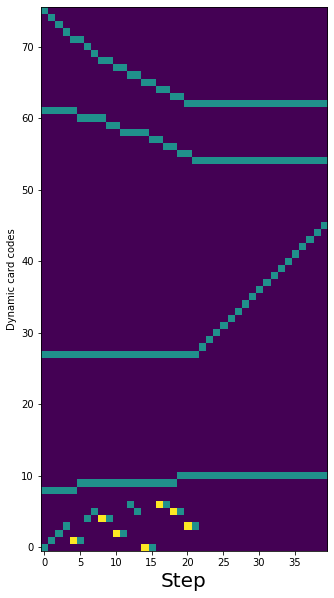

In [23]:
plt.figure(figsize=(20,10))
plt.xlabel('Step', fontsize=20)
plt.ylabel('Dynamic card codes')
plt.imshow(image, origin='lower')

In [24]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
img = image.reshape(image.shape[0], image.shape[1], 1)
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

activations = activation_model.predict(img_tensor) 

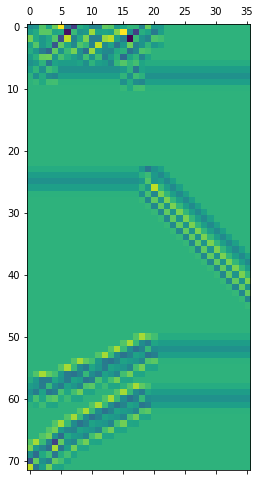

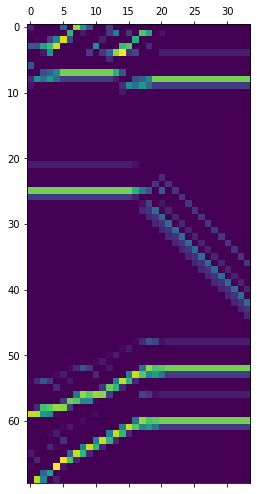

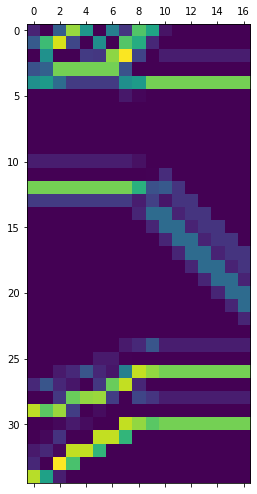

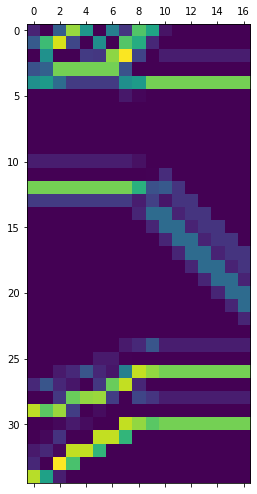

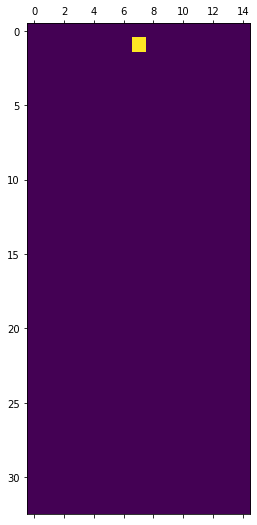

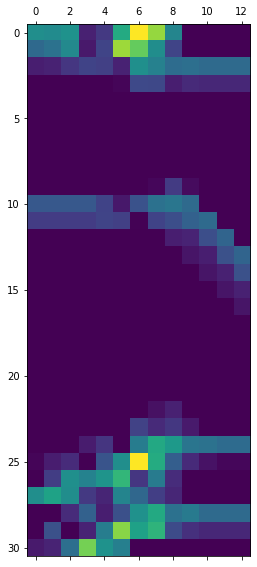

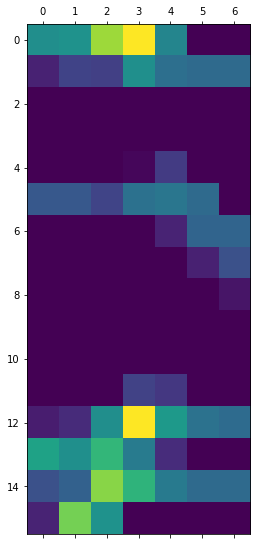

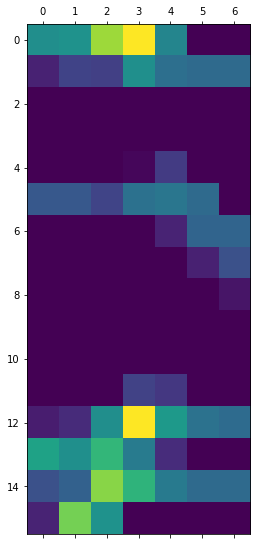

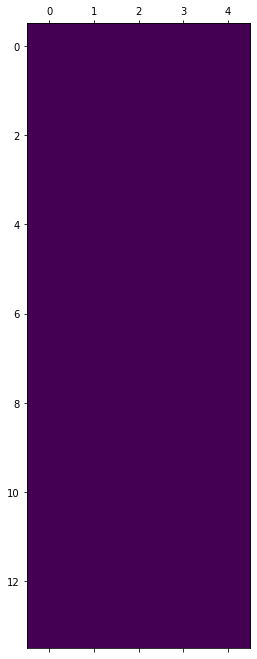

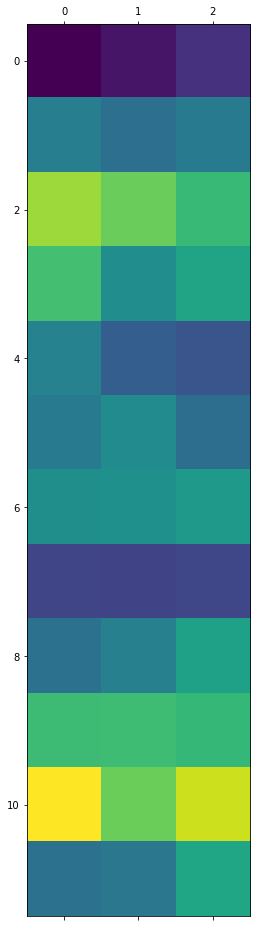

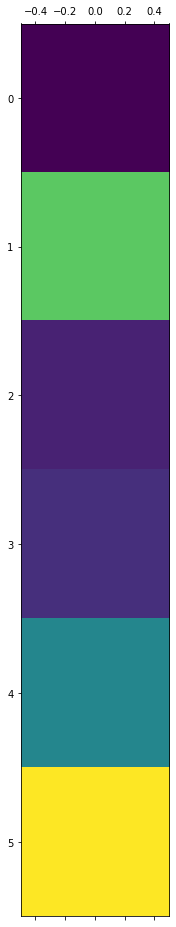

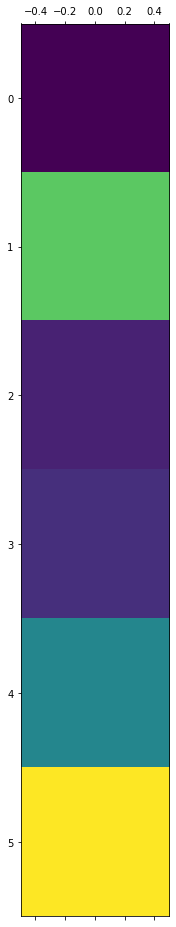

In [67]:
for i in range(12):
    first_layer_activation = activations[i]
    plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [ ]:
mean_val_losses, mean_val_accuracies, mean_losses, mean_accuracies = mean_score_over_all_runs(mean_run_scores, n_runs)
mean_val_accuracies

In [ ]:
plt.title('glareObs_noAdapt: Best validation accuracy %s%% (at epoch %s)' \
          %(round(mean_val_accuracies.max() * 100, 2), np.argmax(mean_val_accuracies) + 1))
plt.plot(mean_accuracies)
plt.plot(mean_val_accuracies)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train(RD_SD%sx)' %n_added_simulations_per_participant, 'validation(RD)'], loc='lower right')
plt.show()

In [ ]:
plt.title('glareObs_noAdapt: Lowest validation loss %s (at epoch %s)' \
          %(round(mean_val_losses.min(), 4), np.argmin(mean_val_losses) + 1))
plt.plot(mean_losses)
plt.plot(mean_val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train(RD_SD%sx)' %n_added_simulations_per_participant, 'validation(RD)'], loc='upper right')
plt.show()